# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [106]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#pd.set_option('display.max_rows', None)

In [107]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [108]:
df = df.copy()

In [109]:
len(df)

541909

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [111]:
df.loc[df['CustomerID'].isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


In [112]:
#df.to_csv("Online_Retail.csv", index= False)

In [113]:
print("Total data:", len(df))

Total data: 541909


In [114]:
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [115]:
weird_data = df[(df.Quantity < 0) | ( df.UnitPrice < 0)]

In [116]:
len(weird_data)

10626

Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [117]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [118]:
null_percentage = (135080 / 541909) * 100
null_percentage

24.926694334288598

In [119]:
df_notna = df.loc[df["CustomerID"].notna(), :]
df_notna.shape

(406829, 8)

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [120]:
# Remove missing value
df = df[df["CustomerID"].notna()]
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [121]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [122]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [123]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 397884 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [125]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

In [126]:
# df['Country_isUK'] = df['Country'].apply(lambda x: 'UK' if x == 'United Kingdom' else 'Non UK')

In [127]:
%%timeit
df['Country'].apply(lambda x: "UK" if x == "United Kingdom" else "Non UK")

64.4 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [128]:
%%timeit
np.where(df['Country'].values == 'United Kingdom', 'UK', 'Non UK')

16 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
(67.2 - 15.3)/67.2 , (1 - ((67.2 - 15.3)/67.2)) * 60

(0.7723214285714286, 13.660714285714285)

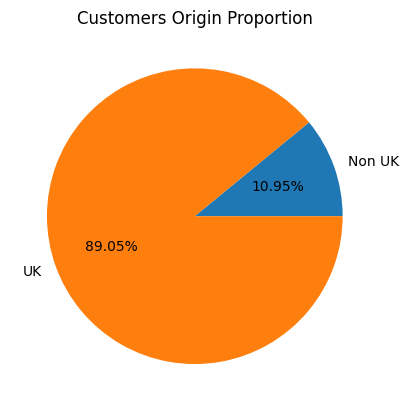

In [130]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')
customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [131]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [132]:
import matplotlib.dates as mdates

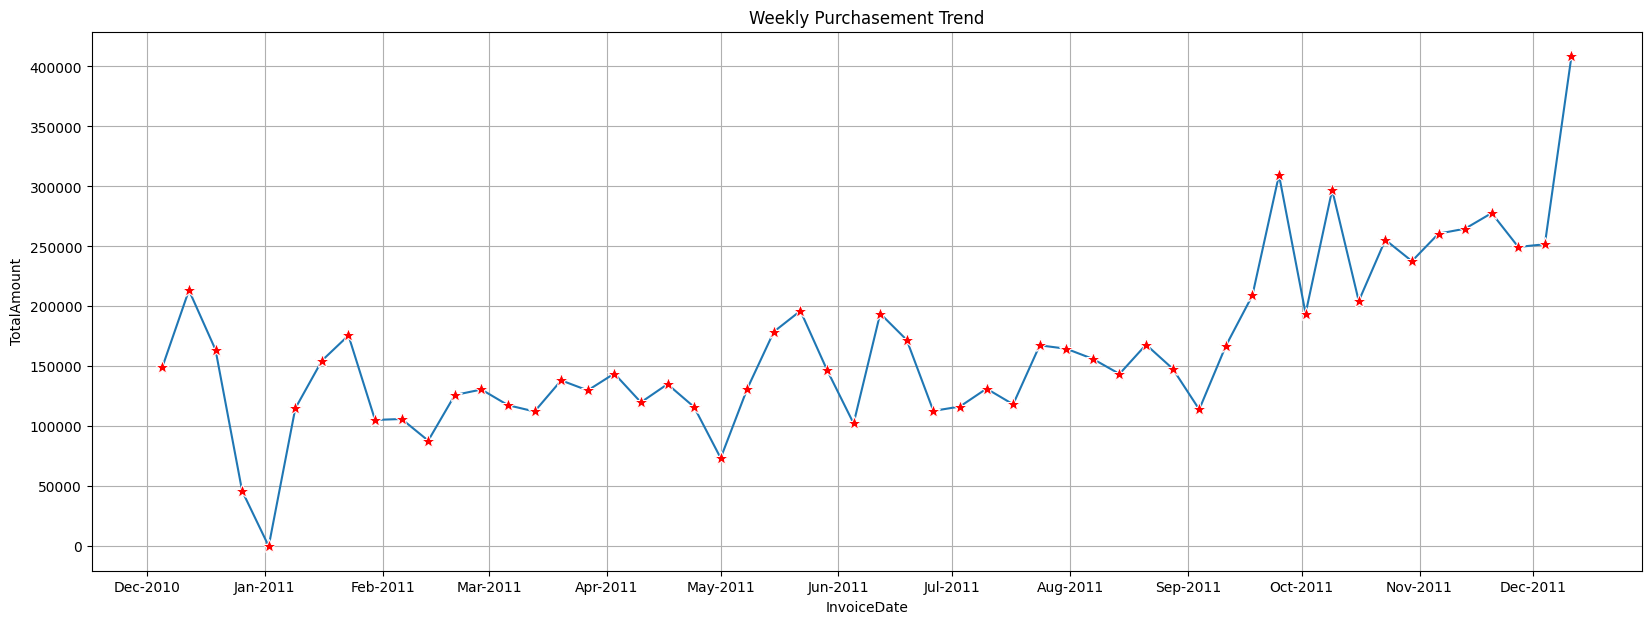

In [133]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

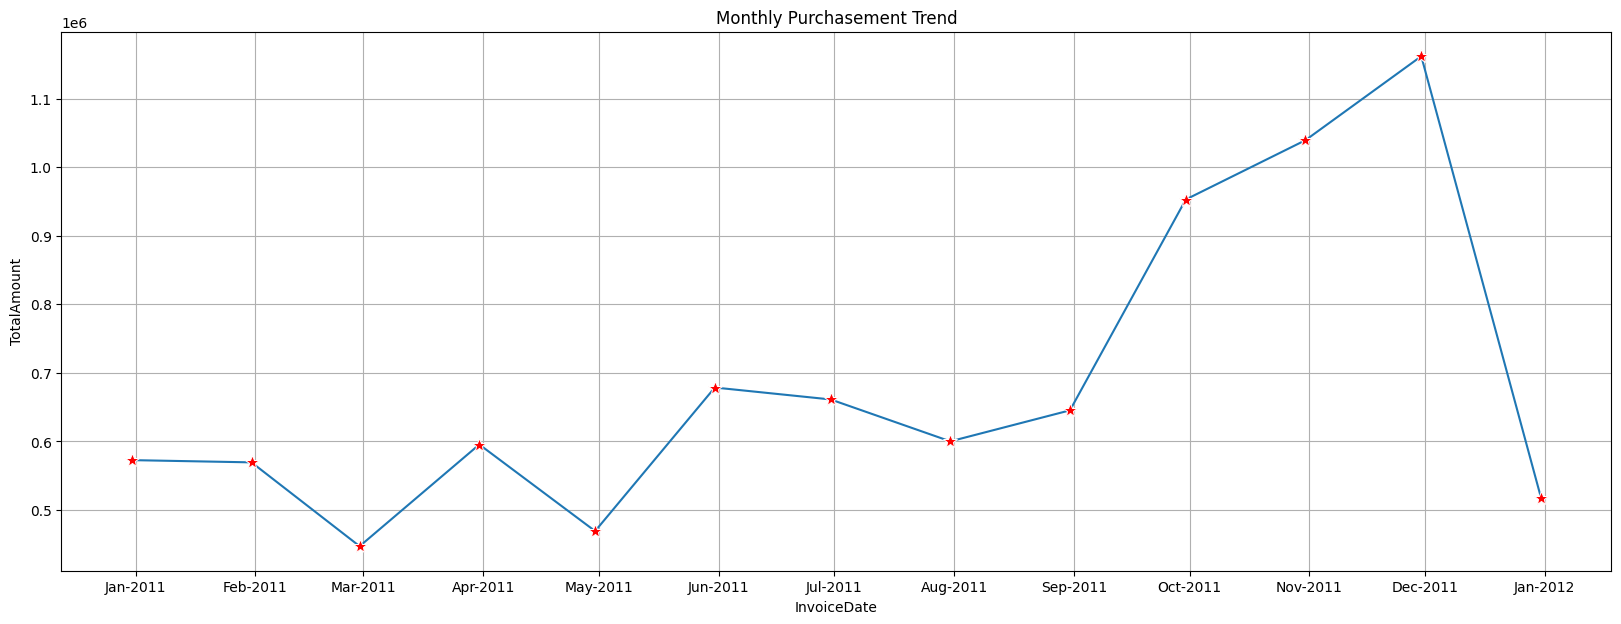

In [134]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [135]:
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency.head(10)

CustomerID
12346.0   2011-01-18 10:01:00
12347.0   2011-12-07 15:52:00
12348.0   2011-09-25 13:13:00
12349.0   2011-11-21 09:51:00
12350.0   2011-02-02 16:01:00
12352.0   2011-11-03 14:37:00
12353.0   2011-05-19 17:47:00
12354.0   2011-04-21 13:11:00
12355.0   2011-05-09 13:49:00
12356.0   2011-11-17 08:40:00
Name: InvoiceDate, dtype: datetime64[ns]

In [136]:
max(recency)

Timestamp('2011-12-09 12:50:00')

In [137]:
recency = max(recency) - recency
recency.head(10)

CustomerID
12346.0   325 days 02:49:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
12352.0    35 days 22:13:00
12353.0   203 days 19:03:00
12354.0   231 days 23:39:00
12355.0   213 days 23:01:00
12356.0    22 days 04:10:00
Name: InvoiceDate, dtype: timedelta64[ns]

In [138]:
# Get customer's recency
#recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
#recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

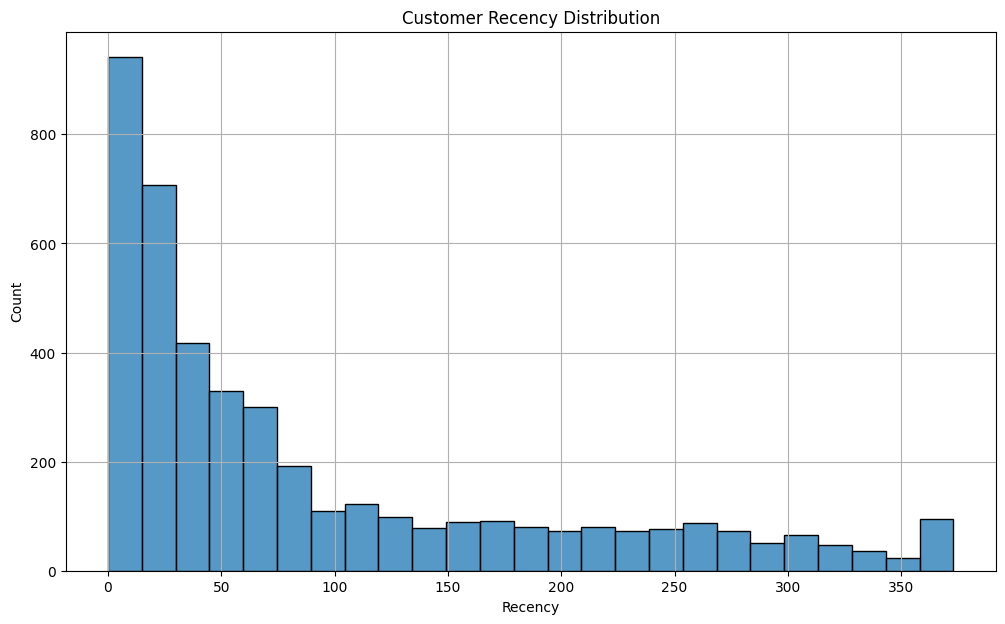

In [139]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [140]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


In [141]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
#jika menggunakan .value_counts() maka akan dihitung nilai perkolom InvoiceNo
frequency = frequency.rename('Frequency')
frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

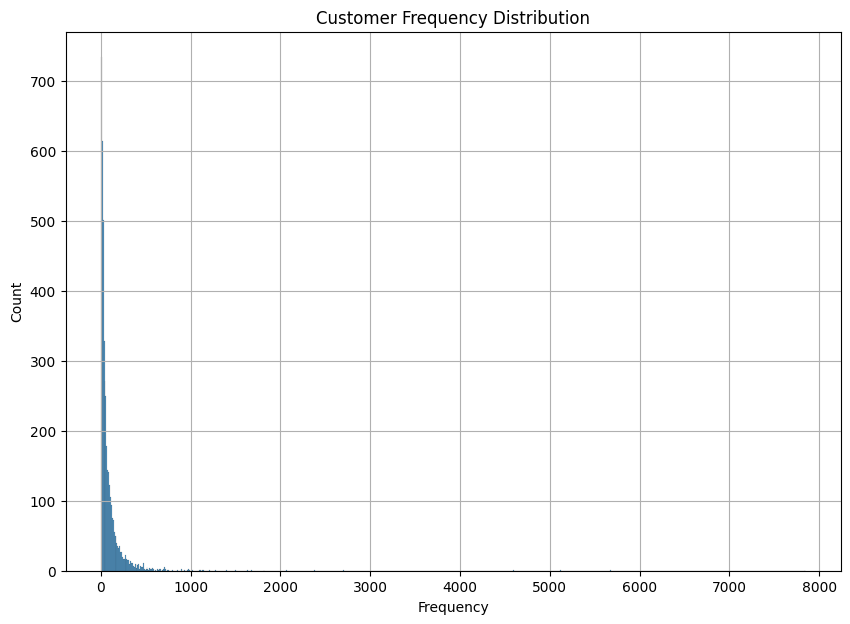

In [142]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

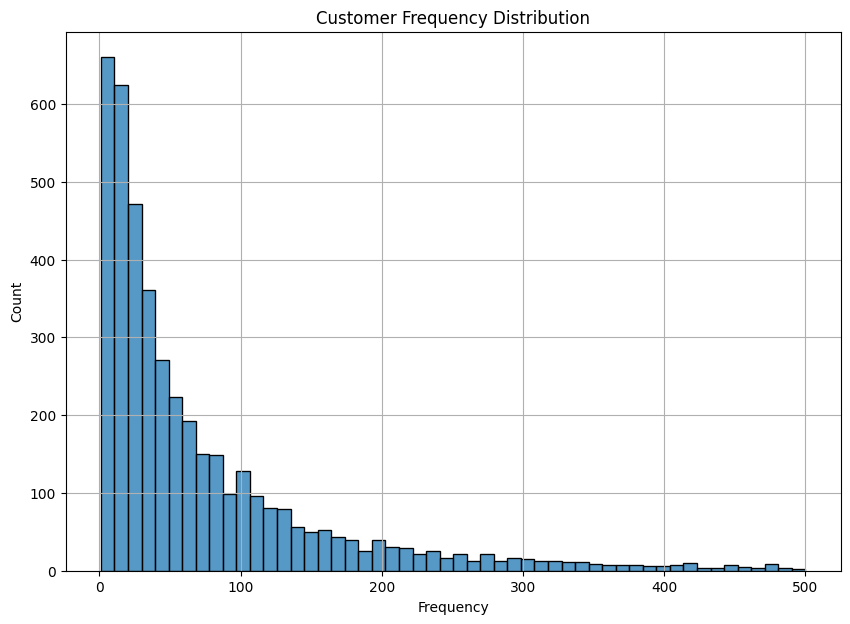

In [143]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency[frequency <= 500])
plt.grid()
plt.show();

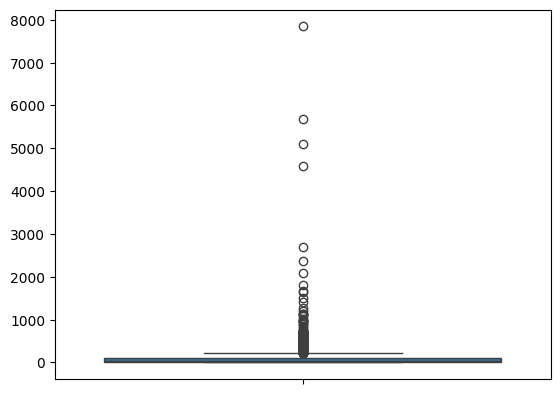

In [144]:
sns.boxplot(frequency.values);

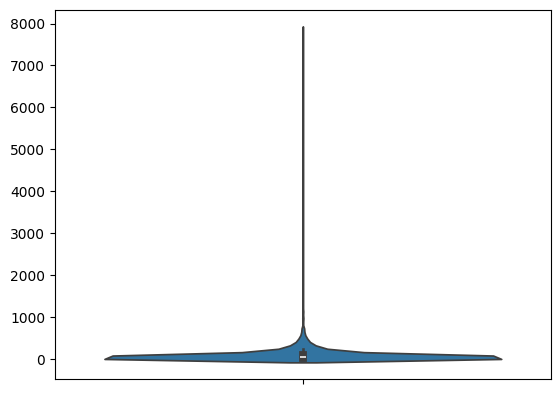

In [145]:
sns.violinplot(frequency.values);

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [146]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

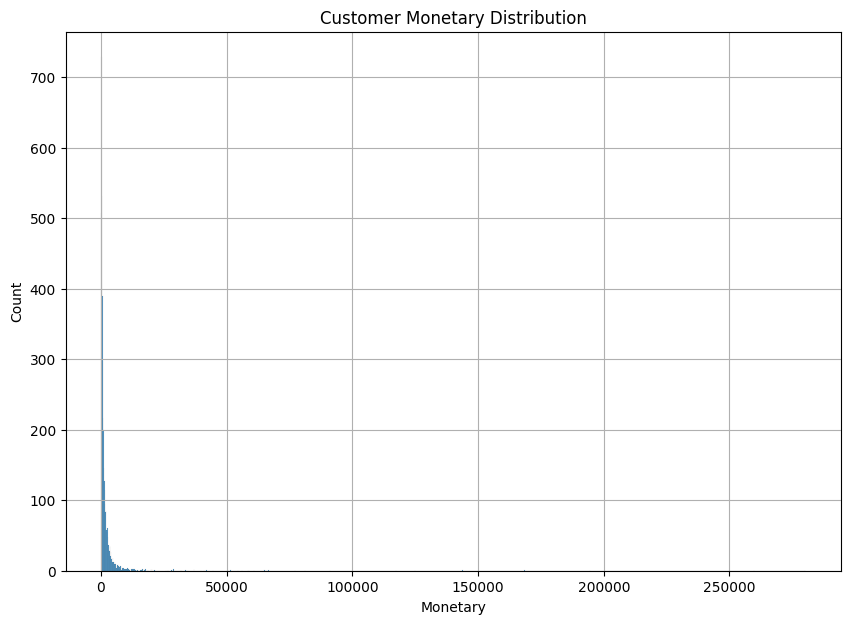

In [147]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

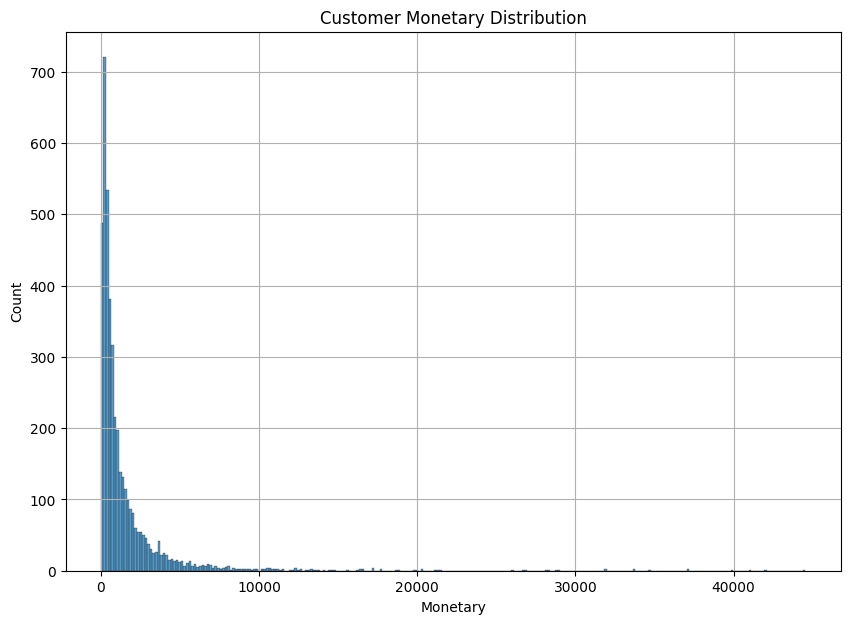

In [148]:
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary[monetary < 50000])
plt.grid()
plt.show()

### Merge the Data

The data should be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) should be used when visualize the result.

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     397884 non-null  object        
 1   StockCode     397884 non-null  object        
 2   Description   397884 non-null  object        
 3   Quantity      397884 non-null  int64         
 4   InvoiceDate   397884 non-null  datetime64[ns]
 5   UnitPrice     397884 non-null  float64       
 6   CustomerID    397884 non-null  float64       
 7   Country       397884 non-null  object        
 8   Country_isUK  397884 non-null  object        
 9   TotalAmount   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 33.4+ MB


In [150]:
(
    df
    .groupby(['CustomerID', 'Country_isUK']) #define as the index column
    .size()
    .reset_index()
    .drop(0, axis=1)
)

,CustomerID,Country_isUK
0,12346.0,UK
1,12347.0,Non UK
2,12348.0,Non UK
3,12349.0,Non UK
4,12350.0,Non UK
...,...,...
4333,18280.0,UK
4334,18281.0,UK
4335,18282.0,UK
4336,18283.0,UK


In [151]:
# or we can try with another alternative

(
  df
  .groupby(['CustomerID'])['Country_isUK']
  .value_counts()
  .reset_index()
  .drop('count', axis=1)
)

,CustomerID,Country_isUK
0,12346.0,UK
1,12347.0,Non UK
2,12348.0,Non UK
3,12349.0,Non UK
4,12350.0,Non UK
...,...,...
4333,18280.0,UK
4334,18281.0,UK
4335,18282.0,UK
4336,18283.0,UK


In [152]:
# Get customer's country of origin
country = (
    df
    .groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)

# Merge the data
df_new = (
    country
    .merge(recency, on='CustomerID')
    .merge(frequency, on='CustomerID')
    .merge(monetary, on='CustomerID')
)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head(10)

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40
12352.0,Non UK,35,85,2506.04
12353.0,Non UK,203,4,89.00
12354.0,Non UK,231,58,1079.40
12355.0,Non UK,213,13,459.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [153]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True #drop first column 'Country_isUK_NonUK'
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,True
12347.0,1,182,4310.00,False
12348.0,74,31,1797.24,False
12349.0,18,73,1757.55,False
12350.0,309,17,334.40,False


### Scaling

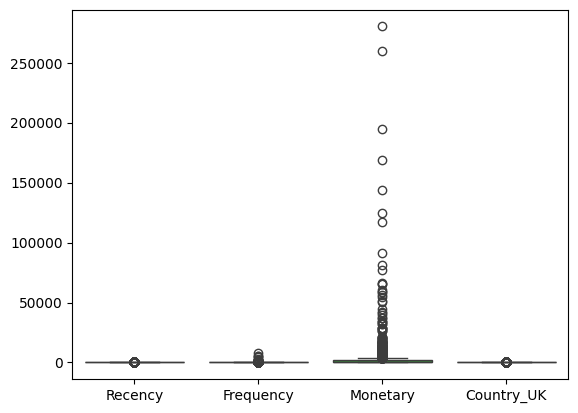

In [154]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [155]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


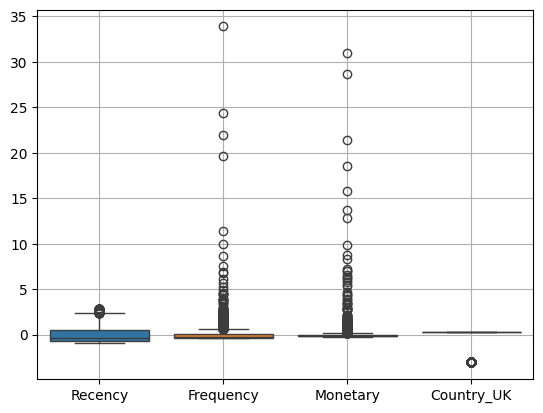

In [156]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [157]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [158]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))
    print(silhouette)

[0.6651876828655108]
[0.6651876828655108, 0.6456328183013904]
[0.6651876828655108, 0.6456328183013904, 0.601973542603982]
[0.6651876828655108, 0.6456328183013904, 0.601973542603982, 0.6004542194308659]
[0.6651876828655108, 0.6456328183013904, 0.601973542603982, 0.6004542194308659, 0.6210754022547084]
[0.6651876828655108, 0.6456328183013904, 0.601973542603982, 0.6004542194308659, 0.6210754022547084, 0.5972246186755064]
[0.6651876828655108, 0.6456328183013904, 0.601973542603982, 0.6004542194308659, 0.6210754022547084, 0.5972246186755064, 0.5349535980323064]
[0.6651876828655108, 0.6456328183013904, 0.601973542603982, 0.6004542194308659, 0.6210754022547084, 0.5972246186755064, 0.5349535980323064, 0.5378123333187462]
[0.6651876828655108, 0.6456328183013904, 0.601973542603982, 0.6004542194308659, 0.6210754022547084, 0.5972246186755064, 0.5349535980323064, 0.5378123333187462, 0.5348421292799594]


As we can see, k=2 and k=6 have peak values and don't have significant decrease

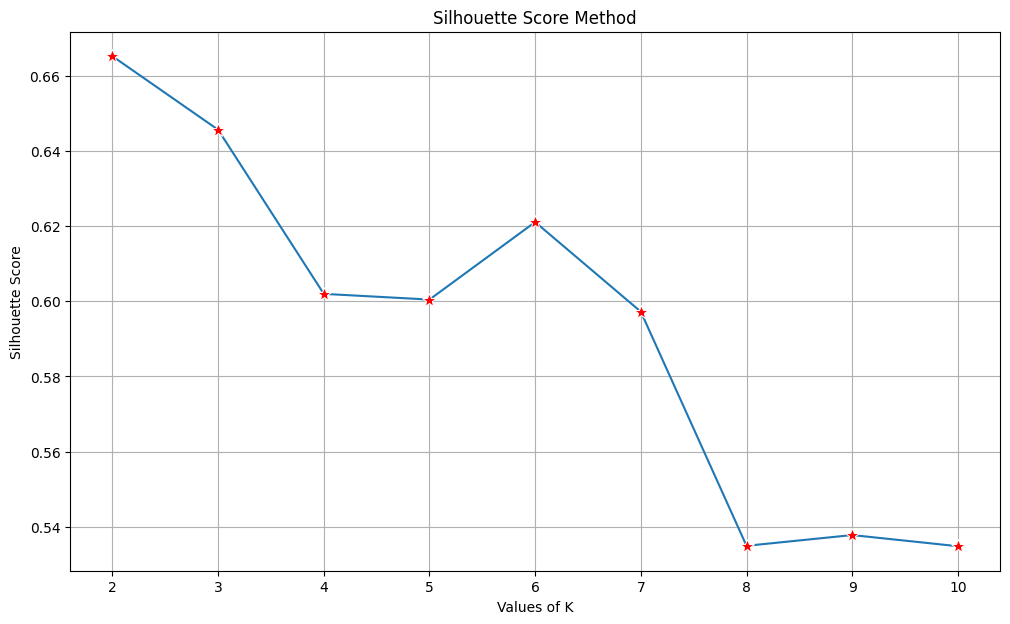

In [159]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2 or 6

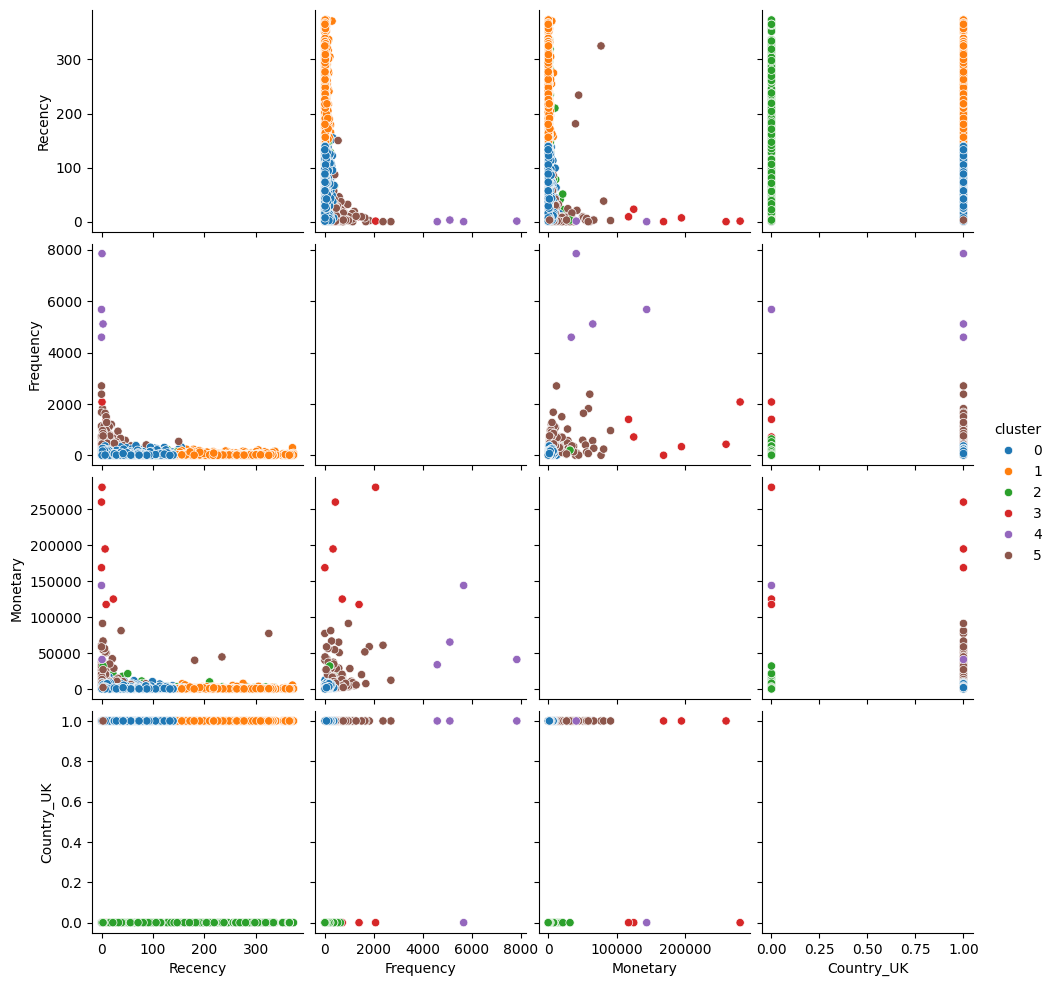

In [160]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [161]:
df_result_kmeans

,Recency,Frequency,Monetary,Country_UK,cluster
CustomerID,,,,,
12346.0,325,1,77183.60,True,5
12347.0,1,182,4310.00,False,2
12348.0,74,31,1797.24,False,2
12349.0,18,73,1757.55,False,2
12350.0,309,17,334.40,False,2
...,...,...,...,...,...
18280.0,277,10,180.60,True,1
18281.0,180,7,80.82,True,1
18282.0,7,12,178.05,True,0


In [162]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0            1             2              3  \
Recency   mean       42.676884   246.776618     95.405797       6.666667   
          std        36.313016    65.636727    104.638705       8.869423   
          min         0.000000   143.000000      0.000000       0.000000   
          q25        14.000000   189.000000     18.000000       0.250000   
          median     31.000000   242.000000     52.000000       4.000000   
          q75        64.000000   296.000000    136.500000       8.500000   
          max       155.000000   373.000000    373.000000      23.000000   
Frequency mean       76.270826    27.689979     81.396135     826.833333   
          std        74.030983    32.176026     96.304061     771.620481   
          min         1.000000     1.000000      1.000000       3.000000   
          q25        22.000000     8.250000     21.250000     360.500000   
          median     51.000000    18.000000     45.000000     572.500000   
          q75       107.000000    33.000000    101.000000    1228.500000   
          max       385.000000   297.000000    638.000000    2076.000000   
Monetary  mean     1341.293935   450.793070   2262.538913  190863.461667   
          std      1592.871914   610.367153   3479.689136   67791.993010   
          min         6.200000     3.750000     51.560000  117379.630000   
          q25       371.700000   163.225000    459.650000  135804.022500   
          median    795.120000   305.515000   1025.700000  181511.645000   
          q75      1720.300000   505.542500   2659.962500  243380.672500   
          max     17654.540000  7832.470000  31906.820000  280206.020000   

cluster                       4             5  
Recency   mean         1.000000     15.234973  
          std          1.414214     35.305176  
          min          0.000000      0.000000  
          q25          0.000000      2.000000  
          median       0.500000      6.000000  
          q75          1.500000     16.000000  
          max          3.000000    325.000000  
Frequency mean      5807.000000    535.360656  
          std       1429.730044    358.078267  
          min       4595.000000      1.000000  
          q25       4982.000000    367.000000  
          median    5393.000000    450.000000  
          q75       6218.000000    589.500000  
          max       7847.000000   2700.000000  
Monetary  mean     70925.287500  13085.065738  
          std      50424.336433  16313.461152  
          min      33719.730000   1093.650000  
          q25      39173.610000   4014.945000  
          median   53078.180000   6923.130000  
          q75      84829.857500  13213.210000  
          max     143825.060000  91062.380000

In [163]:
df_result_kmeans.head(20)

,Recency,Frequency,Monetary,Country_UK,cluster
CustomerID,,,,,
12346.0,325,1,77183.60,True,5
12347.0,1,182,4310.00,False,2
12348.0,74,31,1797.24,False,2
12349.0,18,73,1757.55,False,2
12350.0,309,17,334.40,False,2
12352.0,35,85,2506.04,False,2
12353.0,203,4,89.00,False,2
12354.0,231,58,1079.40,False,2
12355.0,213,13,459.40,False,2


That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

### Recency Quality

In [164]:
df_result_kmeans.Recency.quantile([0.25, 0.5, 0.75])

0.25     17.0
0.50     50.0
0.75    141.0
Name: Recency, dtype: float64

In [165]:
def rqs(recency_score):
  if recency_score < 17:
    return "Low_R"
  elif 17 <= recency_score < 50:
    return "Medium_R"
  elif 50 <= recency_score < 141:
    return "High_R"
  else:
    return "Bad_R"

df_result_kmeans["Recency_Quality"] = df_result_kmeans['Recency'].apply(rqs)
df_result_kmeans.head(20)

,Recency,Frequency,Monetary,Country_UK,cluster,Recency_Quality
CustomerID,,,,,,
12346.0,325,1,77183.60,True,5,Bad_R
12347.0,1,182,4310.00,False,2,Low_R
12348.0,74,31,1797.24,False,2,High_R
12349.0,18,73,1757.55,False,2,Medium_R
12350.0,309,17,334.40,False,2,Bad_R
12352.0,35,85,2506.04,False,2,Medium_R
12353.0,203,4,89.00,False,2,Bad_R
12354.0,231,58,1079.40,False,2,Bad_R
12355.0,213,13,459.40,False,2,Bad_R


In [166]:
df_result_kmeans["Recency_Quality"].value_counts()

Recency_Quality
High_R      1092
Medium_R    1092
Bad_R       1088
Low_R       1066
Name: count, dtype: int64

### Customers Value

In [167]:
df_result_kmeans.Monetary.quantile([0.25, 0.5, 0.75])

0.25     307.415
0.50     674.485
0.75    1661.740
Name: Monetary, dtype: float64

In [168]:
def mcs(customers_category):
  if customers_category < 307.415:
    return "Low_Value"
  elif 307.415 <= customers_category < 674.485:
    return "Mid_Value"
  elif 674.485 <= customers_category < 1661.740:
    return "High_Value"
  else:
    return "Top_Value"

df_result_kmeans['Customers_Value'] = df_result_kmeans['Monetary'].apply(mcs)
df_result_kmeans

,Recency,Frequency,Monetary,Country_UK,cluster,Recency_Quality,Customers_Value
CustomerID,,,,,,,
12346.0,325,1,77183.60,True,5,Bad_R,Top_Value
12347.0,1,182,4310.00,False,2,Low_R,Top_Value
12348.0,74,31,1797.24,False,2,High_R,Top_Value
12349.0,18,73,1757.55,False,2,Medium_R,Top_Value
12350.0,309,17,334.40,False,2,Bad_R,Mid_Value
...,...,...,...,...,...,...,...
18280.0,277,10,180.60,True,1,Bad_R,Low_Value
18281.0,180,7,80.82,True,1,Bad_R,Low_Value
18282.0,7,12,178.05,True,0,Low_R,Low_Value


In [169]:
df_result_kmeans["Customers_Value"].value_counts()

Customers_Value
Top_Value     1085
Low_Value     1085
Mid_Value     1084
High_Value    1084
Name: count, dtype: int64

### Customers Transaction

In [170]:
df_result_kmeans.Frequency.quantile([0.25, 0.5, 0.75])

0.25     17.0
0.50     41.0
0.75    100.0
Name: Frequency, dtype: float64

In [171]:
def fcs(customers_transaction):
  if customers_transaction < 17.0:
    return "Low_Transaction"
  elif 17.0 <= customers_transaction < 41.0:
    return "Mid_Transaction"
  elif 41.0 <= customers_transaction < 100:
    return "High_Transaction"
  else:
    return "Vip"

df_result_kmeans['Customers_Transaction'] = df_result_kmeans['Frequency'].apply(fcs)
df_result_kmeans

,Recency,Frequency,Monetary,Country_UK,cluster,Recency_Quality,Customers_Value,Customers_Transaction
CustomerID,,,,,,,,
12346.0,325,1,77183.60,True,5,Bad_R,Top_Value,Low_Transaction
12347.0,1,182,4310.00,False,2,Low_R,Top_Value,Vip
12348.0,74,31,1797.24,False,2,High_R,Top_Value,Mid_Transaction
12349.0,18,73,1757.55,False,2,Medium_R,Top_Value,High_Transaction
12350.0,309,17,334.40,False,2,Bad_R,Mid_Value,Mid_Transaction
...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,True,1,Bad_R,Low_Value,Low_Transaction
18281.0,180,7,80.82,True,1,Bad_R,Low_Value,Low_Transaction
18282.0,7,12,178.05,True,0,Low_R,Low_Value,Low_Transaction


In [172]:
df_result_kmeans["Customers_Transaction"].value_counts()

Customers_Transaction
High_Transaction    1100
Mid_Transaction     1094
Vip                 1091
Low_Transaction     1053
Name: count, dtype: int64

In [173]:
# import numpy as np

# def rqs(recency_score):
#    thresholds = [17, 50, 141]
#    labels = ["High_R", "Medium_R", "Low_R", "Bad_R"]
#    return labels[np.digitize(recency_score, thresholds, right=True)]

In [174]:
# %timeit df_result_kmeans['Recency'].apply(rqs)

In [175]:
# data_recency = df_result_kmeans['Recency'].values

In [176]:
# %%timeit np.apply_along_axis(rqs, axis=0, arr=data_recency.reshape(1,-1))

In [177]:
# pd.Series(np.apply_along_axis(rqs, axis=0, arr=data_recency.reshape(1,-1))).value_counts()

In [178]:
# np.apply_along_axis(rqs, axis=0, arr=data_recency.reshape(1,-1))

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

### 1. Exploratory Data Analysis

In [179]:
df_result_kmeans.head()

,Recency,Frequency,Monetary,Country_UK,cluster,Recency_Quality,Customers_Value,Customers_Transaction
CustomerID,,,,,,,,
12346.0,325,1,77183.60,True,5,Bad_R,Top_Value,Low_Transaction
12347.0,1,182,4310.00,False,2,Low_R,Top_Value,Vip
12348.0,74,31,1797.24,False,2,High_R,Top_Value,Mid_Transaction
12349.0,18,73,1757.55,False,2,Medium_R,Top_Value,High_Transaction
12350.0,309,17,334.40,False,2,Bad_R,Mid_Value,Mid_Transaction


a. Top 5 Customers

In [180]:
grpcount = pd.DataFrame(df_result_kmeans.groupby('CustomerID')['Frequency'].sum())
grpcount_ = grpcount.sort_values(by = 'Frequency', ascending = False).head(5).reset_index()

In [181]:
grpcount_['CustomerID'] = grpcount_['CustomerID'].astype(str)

In [182]:
grpcount_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  5 non-null      object
 1   Frequency   5 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


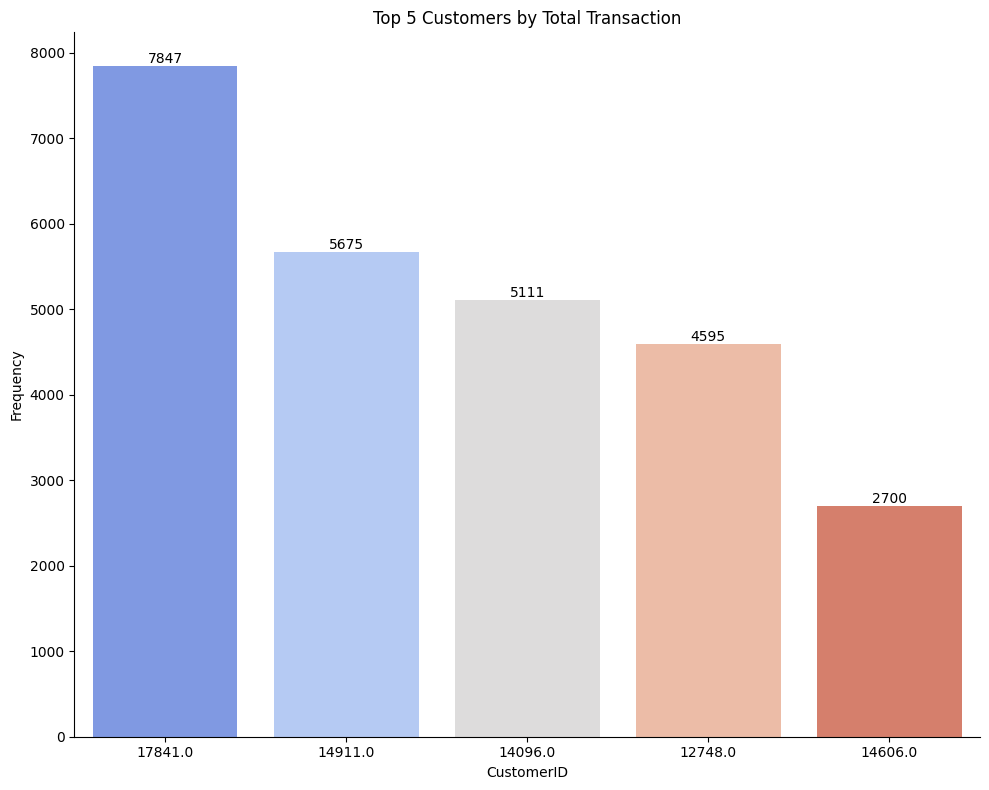

In [183]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='CustomerID', y='Frequency', data=grpcount_, palette='coolwarm')

ax.set_title('Top 5 Customers by Total Transaction')

for p in ax.patches:
    plt.text(p.get_x() + p.get_width()/2., p.get_height(), '{:.0f}'.format(p.get_height()),
             ha='center', va='bottom')

plt.tight_layout()
sns.despine()
plt.show()

b. Peak of Transaction in hour, day, week, and month

Hourly Transaction

In [184]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,Non UK,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,Non UK,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,Non UK,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,Non UK,16.60


In [185]:
hours_purchasements = df.groupby(['CustomerID'])['InvoiceDate'].mean()
hours_purchasements = hours_purchasements.dt.hour

In [186]:
hours_purchasements.describe()

count    4338.000000
mean       11.977178
std         5.834643
min         0.000000
25%         8.000000
50%        12.000000
75%        16.000000
max        23.000000
Name: InvoiceDate, dtype: float64

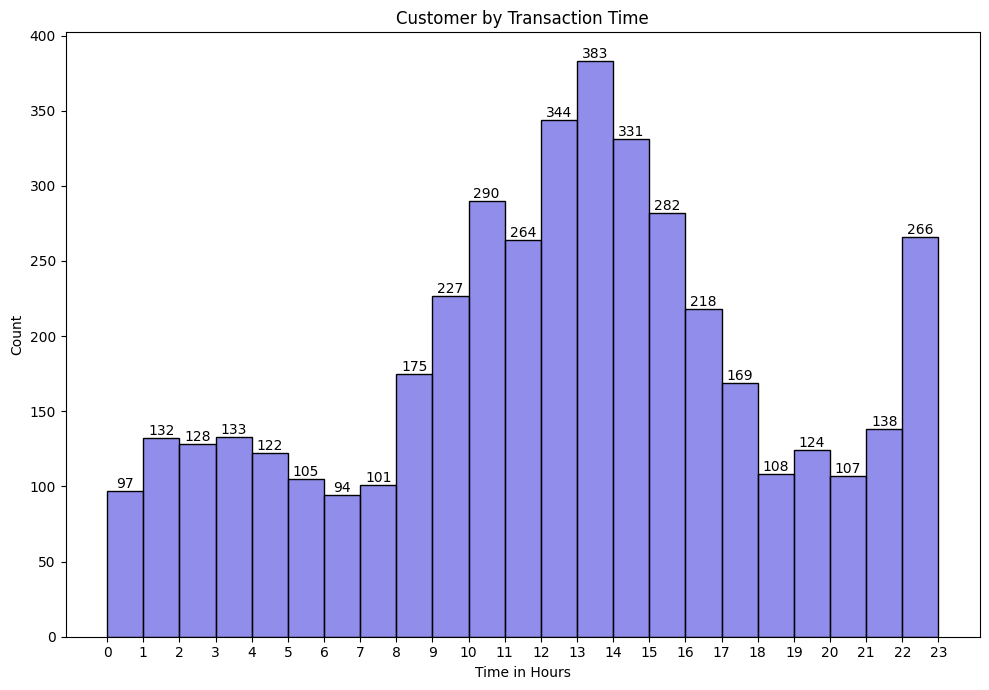

In [187]:
plt.figure(figsize=(10, 7))
ax = sns.histplot(hours_purchasements, bins=23, color='#6D67E4')

for p in ax.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2., height,
             '{:.0f}'.format(height),
             ha='center', va='bottom')

plt.title('Customer by Transaction Time')
plt.xlabel('Time in Hours')
plt.xticks(ticks=range(24),
           labels=[str(i) for i in range(24)])
plt.tight_layout()
plt.show()

Daily Transaction

In [188]:
days_purchasements = df.groupby(['CustomerID'])['InvoiceDate'].mean()
days_purchasements = days_purchasements.dt.day_name()
days_purchasements.value_counts()

InvoiceDate
Thursday     754
Tuesday      670
Wednesday    670
Monday       643
Friday       600
Sunday       597
Saturday     404
Name: count, dtype: int64

In [189]:
days_purchasements.describe()

count         4338
unique           7
top       Thursday
freq           754
Name: InvoiceDate, dtype: object

TypeError: 'Series' object cannot be interpreted as an integer

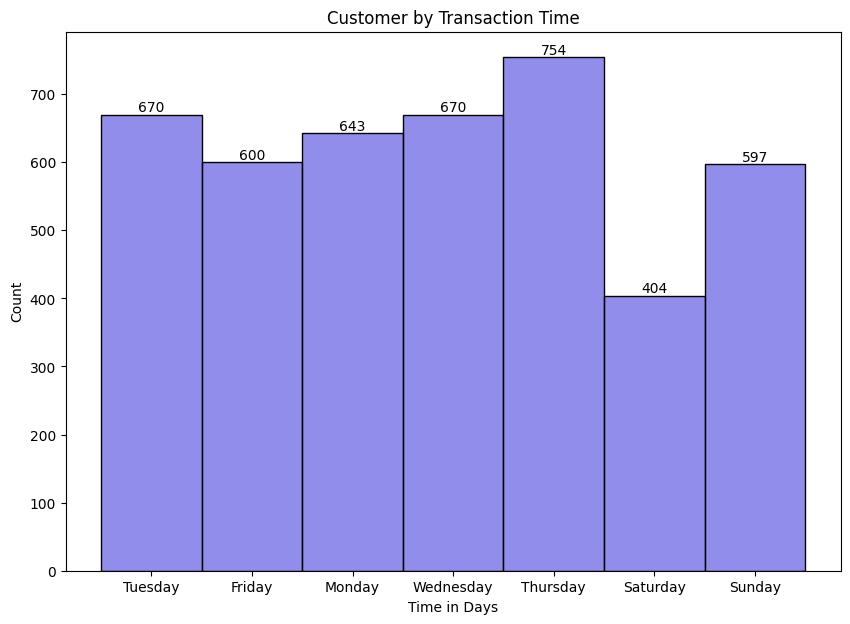

In [190]:
plt.figure(figsize=(10, 7))
ax = sns.histplot(days_purchasements, bins=6, color='#6D67E4')

for p in ax.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2., height,
             '{:.0f}'.format(height),
             ha='center', va='bottom')

plt.title('Customer by Transaction Time')
plt.xlabel('Time in Days')
plt.xticks(ticks=days_purchasements, labels=[str(i) for i in range(days_purchasements)])
plt.tight_layout()
plt.show()

Weekly Transaction

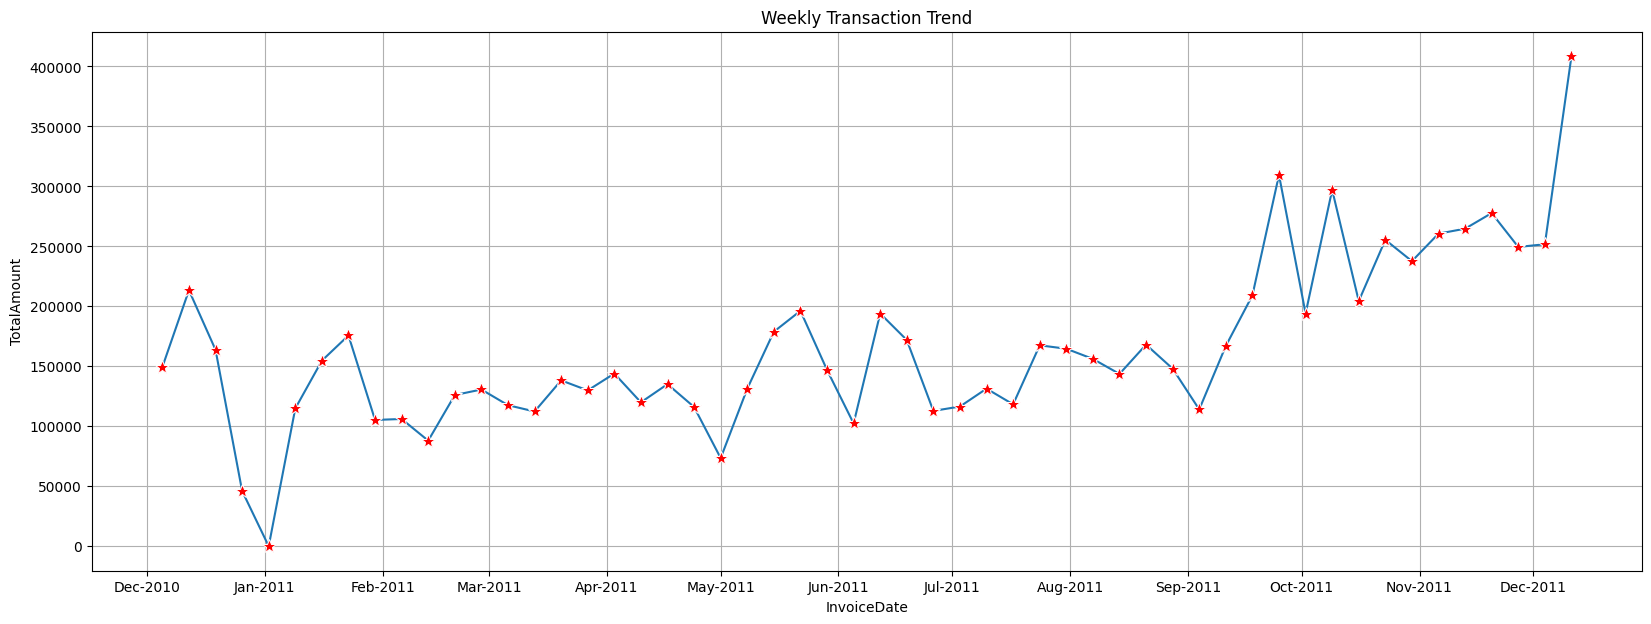

In [191]:
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Transaction Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Monthly Transaction

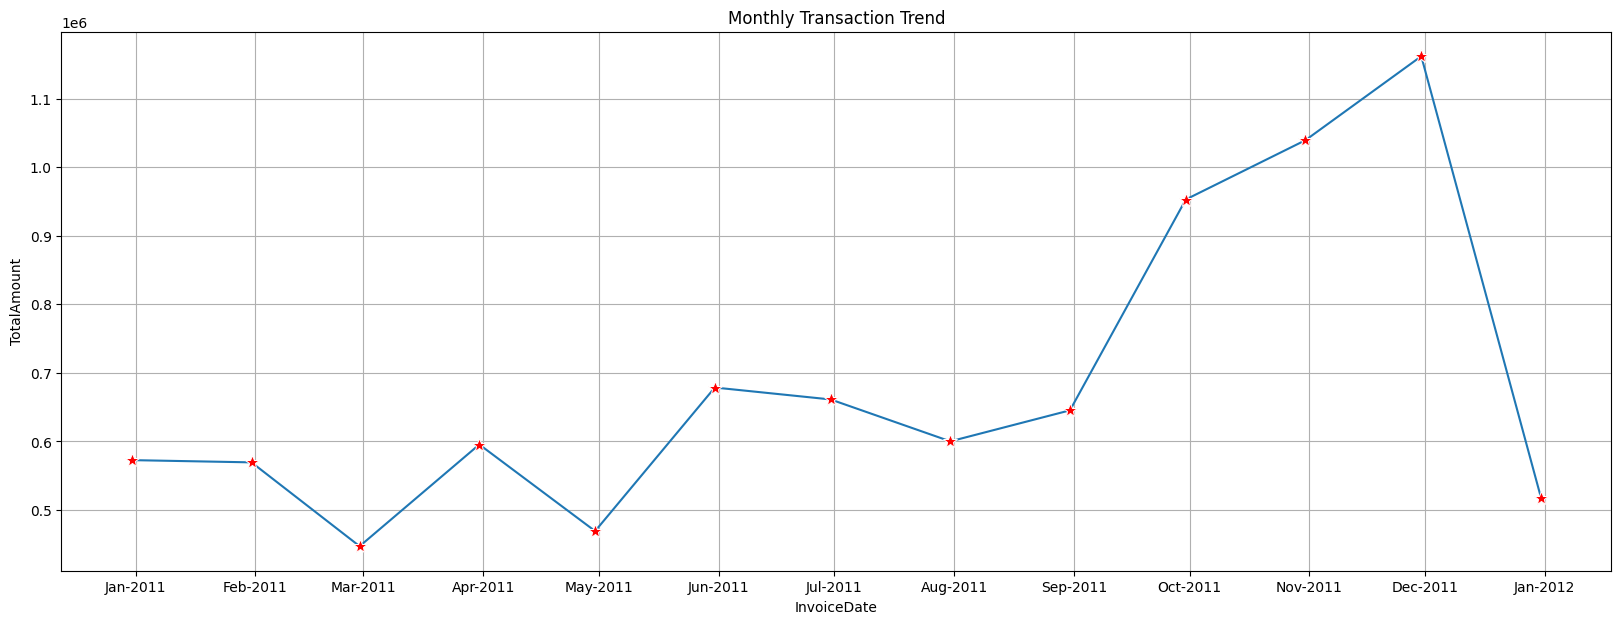

In [192]:
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Transaction Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

### 2. Cluster Analysis



In [193]:
df_result_kmeans

,Recency,Frequency,Monetary,Country_UK,cluster,Recency_Quality,Customers_Value,Customers_Transaction
CustomerID,,,,,,,,
12346.0,325,1,77183.60,True,5,Bad_R,Top_Value,Low_Transaction
12347.0,1,182,4310.00,False,2,Low_R,Top_Value,Vip
12348.0,74,31,1797.24,False,2,High_R,Top_Value,Mid_Transaction
12349.0,18,73,1757.55,False,2,Medium_R,Top_Value,High_Transaction
12350.0,309,17,334.40,False,2,Bad_R,Mid_Value,Mid_Transaction
...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,True,1,Bad_R,Low_Value,Low_Transaction
18281.0,180,7,80.82,True,1,Bad_R,Low_Value,Low_Transaction
18282.0,7,12,178.05,True,0,Low_R,Low_Value,Low_Transaction


In [194]:
cluster_object = df_result_kmeans.drop(['Recency', 'Frequency', 'Monetary'], axis=1)

Recency Quality Cluster Analysis

In [195]:
crq = cluster_object.groupby('cluster')['Recency_Quality'].value_counts().reset_index()
crq

,cluster,Recency_Quality,count
0,0,High_R,978
1,0,Medium_R,953
2,0,Low_R,819
3,0,Bad_R,23
4,1,Bad_R,958
5,2,High_R,111
6,2,Bad_R,103
7,2,Medium_R,103
8,2,Low_R,97
9,3,Low_R,5


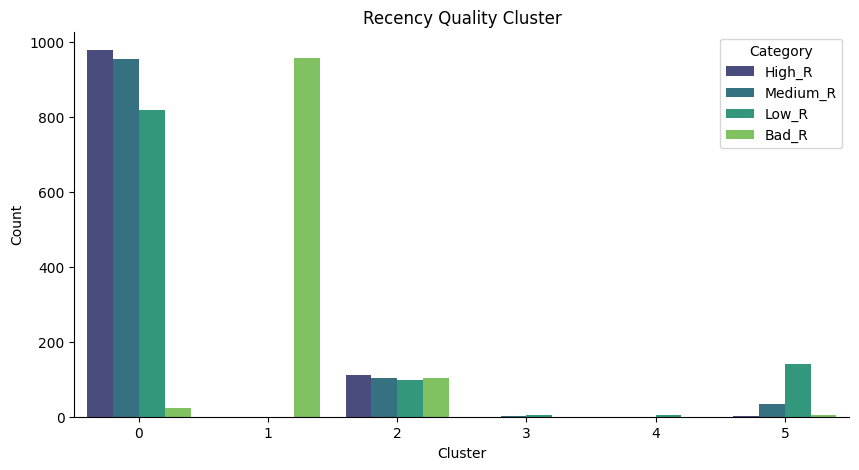

In [196]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='cluster', y='count', hue='Recency_Quality', data=crq, palette='viridis')

ax.set_title('Recency Quality Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')

plt.legend(title='Category')
plt.xticks()
sns.despine()

plt.show()

Customers Value Analysis

In [197]:
ccv = cluster_object.groupby('cluster')['Customers_Value'].value_counts().reset_index()
ccv

,cluster,Customers_Value,count
0,0,High_Value,846
1,0,Top_Value,721
2,0,Mid_Value,667
3,0,Low_Value,539
4,1,Low_Value,488
5,1,Mid_Value,319
6,1,High_Value,125
7,1,Top_Value,26
8,2,Top_Value,149
9,2,High_Value,109


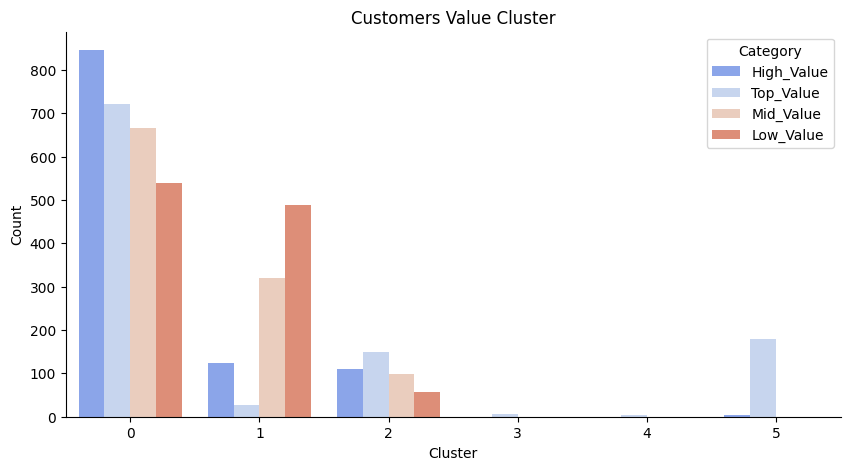

In [198]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='cluster', y='count', hue='Customers_Value', data=ccv, palette='coolwarm')

ax.set_title('Customers Value Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')

plt.legend(title='Category')
plt.xticks()
sns.despine()

plt.show()

Customers Transaction

In [199]:
ctv = cluster_object.groupby('cluster')['Customers_Transaction'].value_counts().reset_index()
ctv

,cluster,Customers_Transaction,count
0,0,High_Transaction,836
1,0,Vip,764
2,0,Mid_Transaction,646
3,0,Low_Transaction,527
4,1,Low_Transaction,447
5,1,Mid_Transaction,325
6,1,High_Transaction,151
7,1,Vip,35
8,2,Mid_Transaction,123
9,2,High_Transaction,109


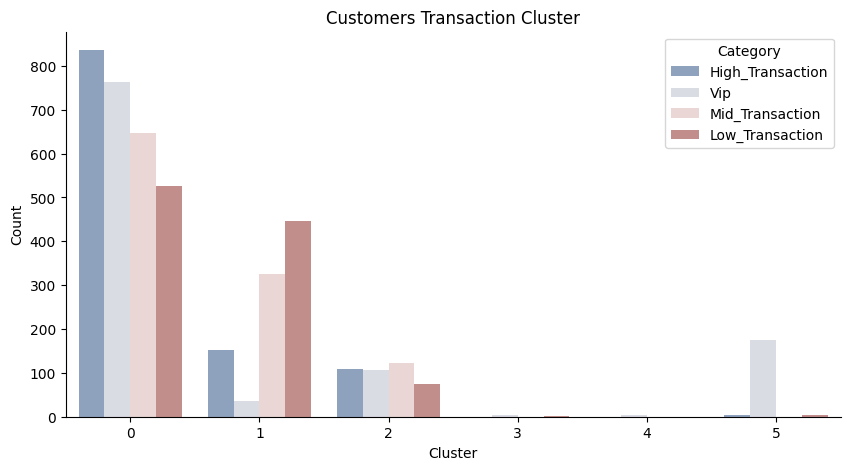

In [200]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='cluster', y='count', hue='Customers_Transaction', data=ctv, palette='vlag')

ax.set_title('Customers Transaction Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')

plt.legend(title='Category')
plt.xticks()
sns.despine()

plt.show()

### Strategy



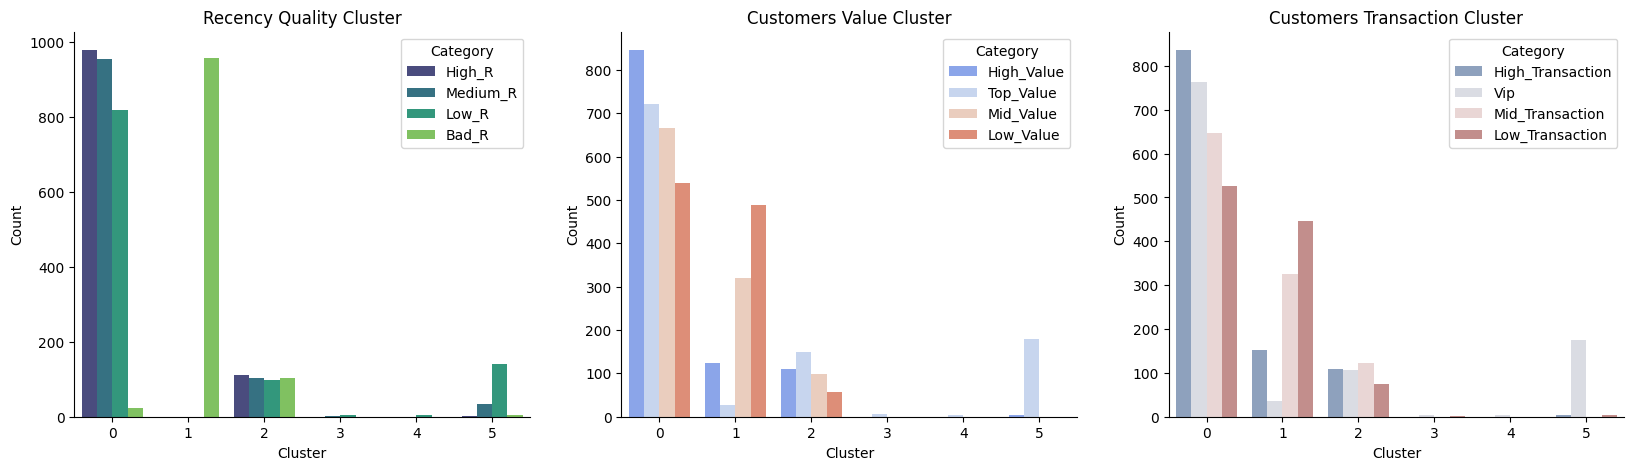

In [201]:
f, ax = plt.subplots(1, 3, figsize=(20,5))

#1. Recency Quality
sns.barplot(x='cluster', y='count', hue='Recency_Quality', data=crq, palette='viridis', ax=ax[0])
ax[0].set_title('Recency Quality Cluster')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Count')
ax[0].legend(title='Category')

#2. Customers Value
sns.barplot(x='cluster', y='count', hue='Customers_Value', data=ccv, palette='coolwarm', ax=ax[1])
ax[1].set_title('Customers Value Cluster')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Count')
ax[1].legend(title='Category')

#3 Customers Transaction
sns.barplot(x='cluster', y='count', hue='Customers_Transaction', data=ctv, palette='vlag', ax=ax[2])
ax[2].set_title('Customers Transaction Cluster')
ax[2].set_xlabel('Cluster')
ax[2].set_ylabel('Count')
ax[2].legend(title='Category')

plt.xticks()
sns.despine()
plt.show();

Strategi Umum: Pertama, Memanfaatkan skema kupon harga karena menurut Jiang (2019) Customers memperoleh lebih banyak surplus dibandingkan dengan skema diskriminasi harga atau skema harga seragam. Kedua, optimasi variasi produk. Dalam hal ini retail perlu meningkatkan variasi produk berdasarkan keunikan dan efisiensi kegunaannya, mengingat barang yang dijual adalah peralatan rumah tangga, (Vijayalakshmi, 2019). Ketiga originalitas dan brand. Ishraq dkk. (2021) menemukan bahwa customers pada *Home Appliance* cenderung mempertimbangkan keaslian brand pada saat berbelanja. Alasannya, karena durabilitas, semakin tinggi tigkat popularitasnya maka berkorelasi dengan daya tahan pemakaiannya.

- Cluster 0 (Loyal Customers) adalah segmen paling potensial di antara segmen lainnya. Pelanggan dalam segmen ini hampir mencakup semua kriteria. Perbedaan utama dalam segmen pelanggan ini terletak pada kategori Frekuensi Berbelanja. Pelanggan ini tergolong aktif dalam berbelanja, dengan kecenderungan berbelanja setidaknya sekali setiap kurang dari 3 bulan, dan biasanya membeli barang dalam jumlah yang cukup banyak sehingga nilai belanjaannya tinggi. Dengan kata lain, pelanggan ini merupakan pelanggan setia dari perusahaan ritel online tersebut.  **Strategi Khusus:** Pertama, Membership Coupon, mengingat cluster ini customersnya loyal, maka perlu mengoptimalkan pemberian kupon dengan menawarkan keanggotaan gratis. Customers mendapatkan benefit seperti promo setiap pembelian (besaran promo tergantung intensitas belanja), informasi produk terbaru, dan mendapatkan cashback (khusus untuk pembelian dalam jumlah tertentu).

- Cluster 1 (High-Value Intermittent Customers) adalah segmen unik di mana pelanggannya termasuk dalam one-time buyer dengan kecenderungan membeli barang dalam jumlah yang sedikit sehingga nilai belanjaannya juga rendah. **Strategi Khusus:** Flash Sale Coupon. Retail menawarkan produk dalam jumlah satuan ataupun banyak dari gudang yang tidak laku (cuci gudang) dengan harga yang murah dalam periode waktu tertentu.

- Cluster 2 Customer Variety-Seeking (CVS) adalah segmen yang kompleks dan cenderung pelanggannya memiliki perilaku pencarian variasi. Artinya, pelanggan dalam segmen ini tidak terpaku pada satu channel ritel untuk berbelanja. Perbedaan dalam merek, kualitas, harga, dll. dapat mempengaruhi pilihan mereka untuk berbelanja. Ini dapat dilihat dari kualitas Recency yang buruk, kecenderungan membeli barang dalam jumlah yang relatif banyak, dan nilai belanjaan yang tinggi. **Strategi Khusus:** Coupon Package (Reguler), karena kecendrungan membeli barang yang banyak dalam satu waktu maka retail dapat menawarkan promo dalam berbagai paket produk. Setiap paketnya berisi jenis dan jumlah produk yang berbeda. Bedanya dalam kupon ini promo diurutkan berdasarkan brand.

- Cluster 3 dan 4 adalah segmen non-prioritas, yang berarti mereka tidak memberikan kontribusi analisis yang signifikan terhadap bisnis.

- Cluster 5 (Low-Value Intermittent Customers juga merupakan segmen unik yang merupakan kebalikan dari Cluster 1, one-time buyer, tetapi dengan kecenderungan membeli barang dalam jumlah yang banyak sehingga nilai belanjaannya juga tinggi. **Strategi Khusus:** Coupon Decoy, retail memberikan tiga kupon pada saat customers ingin melakukan pembelian. Kupon pertama, retail menawarkan satu produk dengan harga normal. Kupon kedua, retail menawarkan sejumlah produk dengan harga normal. Kupon ketiga, retail menawarkan jumlah produk yang sama, tetapi lebih murah dari kupon kedua.


In [202]:
df_all = df.merge(cluster_object, on='CustomerID')

# Set CustomerID as index
df_all = df_all.set_index('CustomerID')
df_all.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Country_isUK,TotalAmount,Country_UK,cluster,Recency_Quality,Customers_Value,Customers_Transaction
CustomerID,,,,,,,,,,,,,,
17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,UK,15.30,True,1,Bad_R,Top_Value,Vip
17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,UK,20.34,True,1,Bad_R,Top_Value,Vip
17850.0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,UK,22.00,True,1,Bad_R,Top_Value,Vip
17850.0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,UK,20.34,True,1,Bad_R,Top_Value,Vip
17850.0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,UK,20.34,True,1,Bad_R,Top_Value,Vip
17850.0,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,United Kingdom,UK,15.30,True,1,Bad_R,Top_Value,Vip
17850.0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,United Kingdom,UK,25.50,True,1,Bad_R,Top_Value,Vip
17850.0,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,United Kingdom,UK,11.10,True,1,Bad_R,Top_Value,Vip
17850.0,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,United Kingdom,UK,11.10,True,1,Bad_R,Top_Value,Vip


### 3. Non UK Segmentation Analysis

In [203]:
df_result_kmeans

,Recency,Frequency,Monetary,Country_UK,cluster,Recency_Quality,Customers_Value,Customers_Transaction
CustomerID,,,,,,,,
12346.0,325,1,77183.60,True,5,Bad_R,Top_Value,Low_Transaction
12347.0,1,182,4310.00,False,2,Low_R,Top_Value,Vip
12348.0,74,31,1797.24,False,2,High_R,Top_Value,Mid_Transaction
12349.0,18,73,1757.55,False,2,Medium_R,Top_Value,High_Transaction
12350.0,309,17,334.40,False,2,Bad_R,Mid_Value,Mid_Transaction
...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,True,1,Bad_R,Low_Value,Low_Transaction
18281.0,180,7,80.82,True,1,Bad_R,Low_Value,Low_Transaction
18282.0,7,12,178.05,True,0,Low_R,Low_Value,Low_Transaction


In [204]:
non_uk = df_result_kmeans.drop(df_result_kmeans[df_result_kmeans['Country_UK']==True].index, axis=0).reset_index()

In [205]:
cluster_non_uk = non_uk.drop(['Recency', 'Frequency', 'Monetary', 'Country_UK'], axis=1)

In [206]:
crq_non_uk = cluster_non_uk.groupby('cluster')['Recency_Quality'].value_counts().reset_index()
ccv_non_uk = cluster_non_uk.groupby('cluster')['Customers_Value'].value_counts().reset_index()
ctv_non_uk = cluster_non_uk.groupby('cluster')['Customers_Transaction'].value_counts().reset_index()

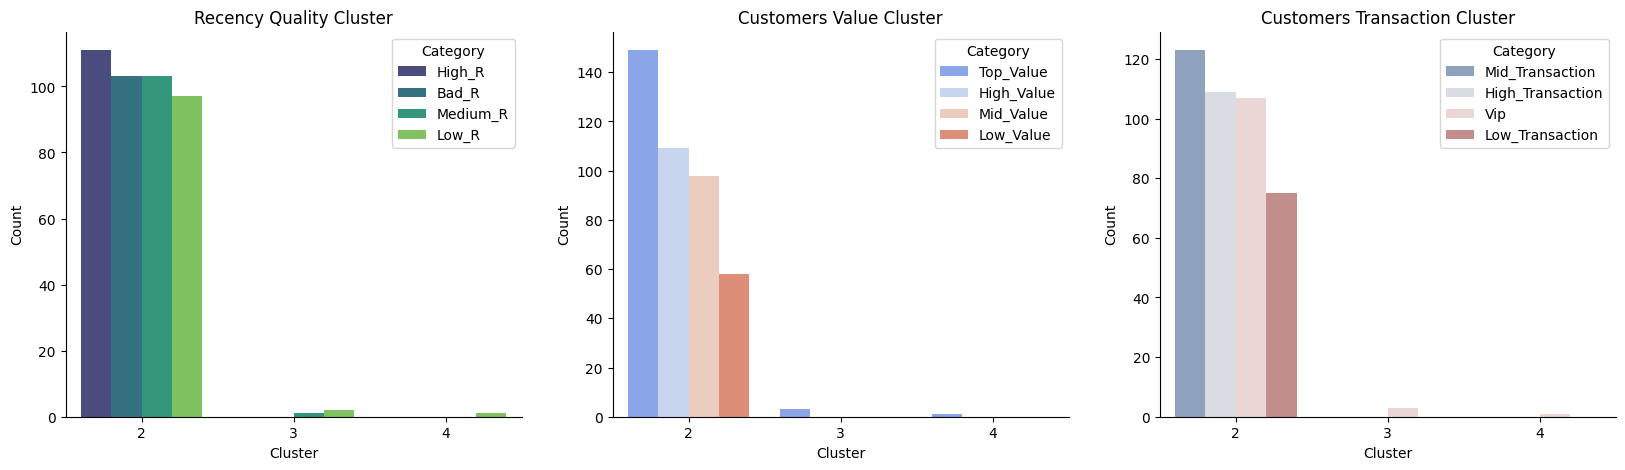

In [207]:
f, ax = plt.subplots(1, 3, figsize=(20,5))

#1. Recency Quality of Non UK
sns.barplot(x='cluster', y='count', hue='Recency_Quality', data=crq_non_uk, palette='viridis', ax=ax[0])
ax[0].set_title('Recency Quality Cluster')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Count')
ax[0].legend(title='Category')

#2. Customers Value of Non UK
sns.barplot(x='cluster', y='count', hue='Customers_Value', data=ccv_non_uk, palette='coolwarm', ax=ax[1])
ax[1].set_title('Customers Value Cluster')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Count')
ax[1].legend(title='Category')

#3 Customers Transaction
sns.barplot(x='cluster', y='count', hue='Customers_Transaction', data=ctv_non_uk, palette='vlag', ax=ax[2])
ax[2].set_title('Customers Transaction Cluster')
ax[2].set_xlabel('Cluster')
ax[2].set_ylabel('Count')
ax[2].legend(title='Category')

plt.xticks()
sns.despine()
plt.show();

## Insight

Untuk customer di luar UK customer segmen didominasi pada cluster 2. Insight yang diperoleh hampir sama dengan cluster 0 jika datanya digabung. Karakteristik dalam cluster ini hampir mencakup semua kriteria. Perbedaan utama dalam segmen pelanggan ini dengan cluster 0 sebelumnya, terletak pada kategori Frekuensi Berbelanja. Walaupun pelanggan ini tergolong relatif aktif dalam berbelanja. Akan tetapi, cukup banyak juga customers yang belanja lebih dari 3 bulan. Dengan kata lain, customers ini termasuk Customers Variety Seeking. Tidak berfokus pada satu channel retail.